In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df = pd.read_csv("RSCCASN.csv",parse_dates=True,index_col="DATE")

In [5]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [7]:
df.columns = ["Sales"]

In [8]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


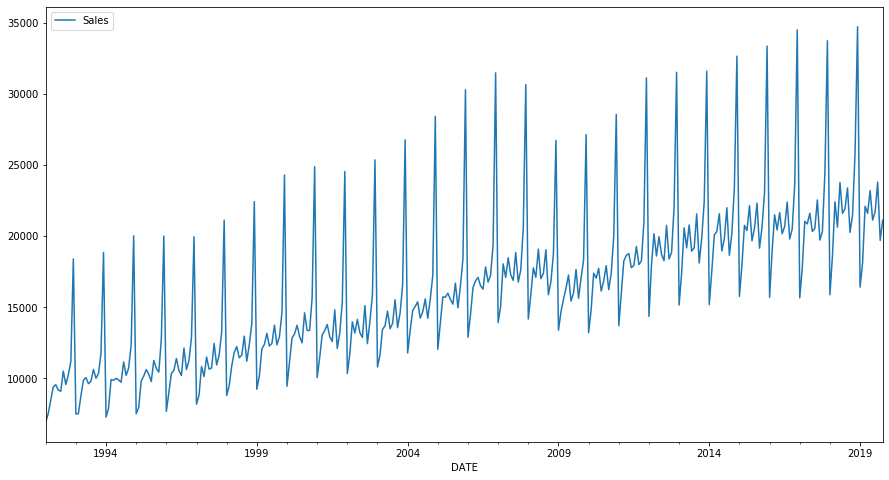

In [10]:
df.plot(figsize=(15,8))

In [11]:
len(df)

334

In [12]:
len(df) - 18

316

In [13]:
test_size = 18
test_ind = len(df) - test_size

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [21]:
scaled_train = scaler.fit_transform(train)

In [22]:
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
length = 12 
generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)


In [24]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [28]:
n_features = 1

In [41]:
model = Sequential()

model.add(LSTM(100,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [43]:
from tensorflow.keras.callbacks import EarlyStopping

In [63]:
early_stop = EarlyStopping(monitor="val_loss",patience=8)

In [64]:
model.fit(generator,epochs=25,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/25
304/304 [==============================] - 3s 10ms/step - loss: 0.0010 - val_loss: 3.2569e-04
Epoch 2/25
304/304 [==============================] - 3s 10ms/step - loss: 9.5761e-04 - val_loss: 2.3512e-04
Epoch 3/25
304/304 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/25
304/304 [==============================] - 3s 10ms/step - loss: 0.0012 - val_loss: 0.0065
Epoch 5/25
304/304 [==============================] - 3s 10ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 6/25
304/304 [==============================] - 3s 10ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 7/25
304/304 [==============================] - 3s 8ms/step - loss: 0.0013 - val_loss: 8.6637e-04
Epoch 8/25
304/304 [==============================] - 3s 10ms/step - loss: 9.0987e-04 - val_loss: 4.8217e-04
Epoch 9/25
304/304 [==============================] - 3s 10ms/step - loss: 9.3266e-04 - val_loss: 4.0469e-04
Epoch 10/25
304/304 [==============================] - 3s 10

In [65]:
losses = pd.DataFrame(model.history.history)

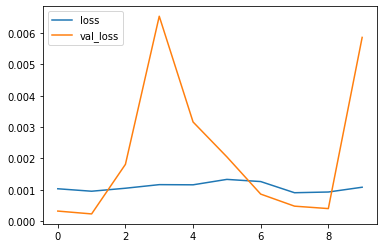

In [66]:
losses.plot()

In [67]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [68]:
true_predictions = scaler.inverse_transform(test_predictions)

In [69]:
test["Predictions"] = true_predictions

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,19455.522151
2018-06-01,21589,18654.077098
2018-07-01,21919,18668.041006
2018-08-01,23381,19824.233829
2018-09-01,20260,18072.615098
2018-10-01,21473,18407.931112
2018-11-01,25831,21214.417940
2018-12-01,34706,29009.392715
2019-01-01,16410,14909.149361


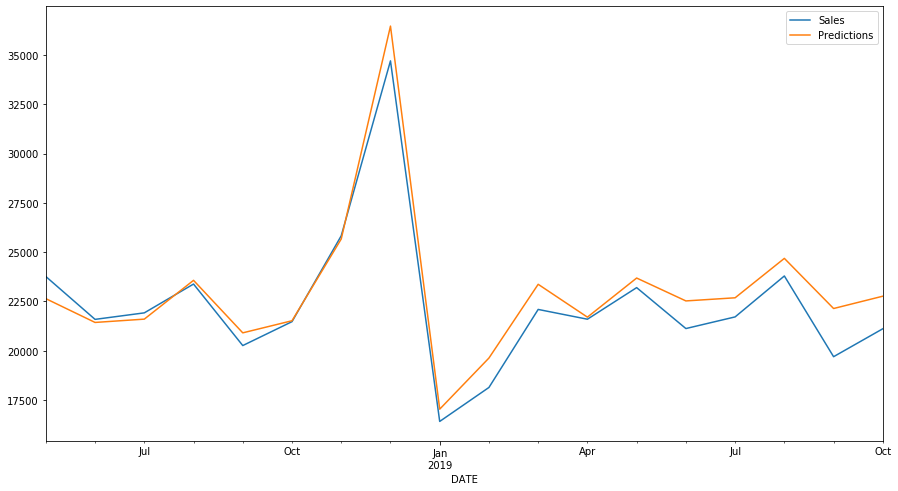

In [61]:
test.plot(figsize=(15,8))

In [71]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [72]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=1)


In [73]:
model = Sequential()

model.add(LSTM(100,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam",loss="mse")

In [74]:
model.fit(generator,epochs=10)

Epoch 1/10
322/322 [==============================] - 3s 9ms/step - loss: 0.0240
Epoch 2/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0169
Epoch 3/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0109
Epoch 4/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0054
Epoch 5/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0033
Epoch 6/10
322/322 [==============================] - 3s 8ms/step - loss: 0.0021
Epoch 7/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0016
Epoch 8/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 9/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0017
Epoch 10/10
322/322 [==============================] - 3s 10ms/step - loss: 0.0013


In [75]:
forecast = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1,length,n_features)

for i in range(12):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [76]:
forecast = scaler.inverse_transform(forecast)

In [77]:
forecast_index = pd.date_range(start="2019-11-01",periods=12,freq = "MS")

In [78]:
forecast_df = pd.DataFrame(forecast,index=forecast_index,columns=["Forecast"])

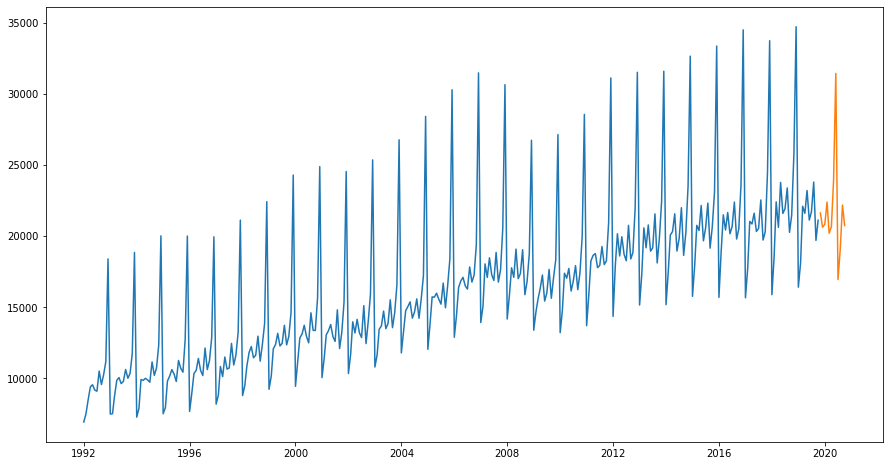

In [80]:
plt.figure(figsize=(15,8))
plt.plot(df)
plt.plot(forecast_df)